# Getting started with SimPy
In this tutorial you will get to know the SimPy module for simulating discrete event systems. In this notebook you will see a complete example derived in small steps and implemented using SimPy, with some simple exercises interspersed. After each exercise, you have the possibility to load the correct solution to check your answer.

Good luck!

## Import modules to be used

In [30]:
%matplotlib inline
import simpy
import random
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

## A model of a small slalom hill
We will consider a model of a small alpine skiing operation with a single lift, quite common in the suburbs of Stockholm.

### Arriving skiiers
We start off with a model of the customers (skiiers) arriving to the facility. At first we consider the customers to arrive randomly with a mean frequency which is constant during the day. In the next step, we will make the model of arrivals more realistic.

The time between arrivals is random and can be modelled as having an exponential distribution. The probability density function of the exponential distribution with mean $\frac{1}{\lambda}$ is 
$$ f(t) = \lambda \mathrm{e}^{-\lambda t}, $$
and the probabilty distribution is
$$ F(t) = \mathrm{Pr}\,(T \le t) = \int_0^t f(\tau)d\tau = 1 - \mathrm{e}^{-\lambda t}. $$
The two functions are plotted below.

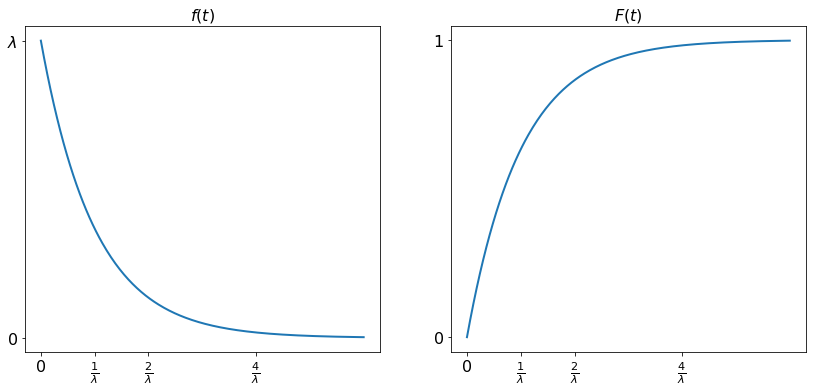

In [57]:
font_size = 16
mpl.rcParams['xtick.labelsize'] = font_size 
mpl.rcParams['ytick.labelsize'] = font_size 
mpl.rcParams['axes.titlesize'] = font_size 
mpl.rcParams['axes.labelsize'] = font_size 

t = np.linspace(0, 6, 300)
lmbda = 1 # The frequency 
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(t, lmbda * np.exp(-t*lmbda), linewidth=2)
plt.yticks([0, lmbda], ['0', '$\lambda$'])
plt.xticks([0, 1/lmbda, 2/lmbda, 4/lmbda], ['0', r'$\frac{1}{\lambda}$', r'$\frac{2}{\lambda}$', r'$\frac{4}{\lambda}$'])
plt.title('$f(t)$')
plt.subplot(1,2,2)
plt.plot(t, 1 - np.exp(-t*lmbda), linewidth=2)
plt.yticks([0, 1], ['0', '1'])
plt.xticks([0, 1/lmbda, 2/lmbda, 4/lmbda], ['0', r'$\frac{1}{\lambda}$', r'$\frac{2}{\lambda}$', r'$\frac{4}{\lambda}$'])
plt.title('$F(t)$')

From the plot of the probabilty density, we see that it is much more common to observe time between arrivals in the interval $\left[0, \; \frac{1}{\lambda}\right]$ $$ p_1 = F(\frac{1}{\lambda}) = 1-\mathrm{e}^{-1} \approx 0.63$$ than in the interval above the mean value $\left[\frac{1}{\lambda}, \; \infty \right)$ $$p_2 = 1 - p_1 \approx 0.37.$$ The single parameter $\lambda$ is the reciprocal  of the mean time, and so it is called the *mean frequency* of the distribution.

#### The customer generator process
We will now implement a random process that generates new arriving skiers. The process goes in an eternal loop, consisting of two steps: 
1. Waiting for a random period of time.
2. Generating a new customer/skier. This is of course and important event in our discrete event system.
The mean frequency of arrivals is one per two minutes. The facility is open from 08:00 ($t=0$) to 16:00 ($t=480$).

In [41]:
def skier_generator_process(env, lmbda, arrivals):
    """ Implementation of the process that generates arriving customers to the facility.
    
        Arguments
        env       --  simpy simulation environment object
        lmbda     --  the mean arrival frequency
        arrivals  --  a list to hold the time of arrivals
    """
   
    k = 0 # A counter to indicate the number of skiers created
    while True:
        # Endless loop
        yield env.timeout(random.expovariate(lmbda)) # Wait for a random interval
        k += 1
        print( "Time is %6.2f and skier %d arrives" % (env.now, k) )
        arrivals.append(env.now) # Register the time of arrival
        
env = simpy.Environment() # Create the simulation environment
lmbda = 0.5 # One arrival per two minutes on average
arr = [] # The list of arrival times
env.process( skier_generator_process(env, lmbda, arr) ) # Tell the simulator to process the skier generator process
env.run(until=30) # To not get too much output below, we simulate the first 30 minutes.

Time is   2.77 and skier 1 arrives
Time is  16.32 and skier 2 arrives
Time is  16.79 and skier 3 arrives
Time is  17.17 and skier 4 arrives
Time is  19.92 and skier 5 arrives
Time is  22.32 and skier 6 arrives
Time is  25.14 and skier 7 arrives
Time is  25.28 and skier 8 arrives
Time is  26.68 and skier 9 arrives


We can check the distribution of the interarrival times by plotting a histogram of the observations. Below we have commented out the print statement in the skier_generator_process, and we simulate for a whole day.

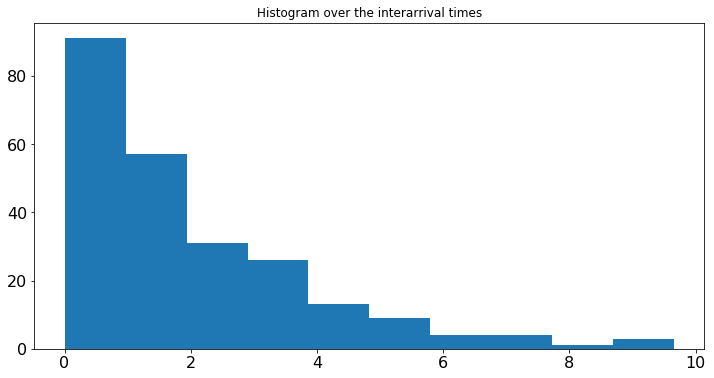

In [42]:
def skier_generator_process(env, lmbda, arrivals):
    """ Implementation of the process that generates arriving customers to the facility.
    
        Arguments
        env       --  simpy simulation environment object
        lmbda     --  the mean arrival frequency
        arrivals  --  a list to hold the time of arrivals
    """
   
    k = 0 # A counter to indicate the number of skiers created
    while True:
        # Endless loop
        yield env.timeout(random.expovariate(lmbda)) # Wait for a random interval
        k += 1
        #print( "Time is %6.2f and skier %d arrives" % (env.now, k) )
        arrivals.append(env.now) # Register the time of arrival
        
env = simpy.Environment() # Create the simulation environment
lmbda = 0.5 # One arrival per two minutes on average
arr = [] # The list of arrival times
env.process( skier_generator_process(env, lmbda, arr) ) # Tell the simulator to process the skier generator process
env.run(until=60*8) # Simulate a day

interArrivalTimes = np.diff(np.array(arr)) # The interarrival times are the difference between the arrival times
plt.figure(figsize=(12,6))
plt.hist(interArrivalTimes)
plt.title('Histogram over the interarrival times')

#### Generating random numbers
To see the available distributions that you can draw samples from with the `random` module do 

In [43]:
?random

And to see information about a particular distribution do

In [44]:
?random.expovariate

### Exercise 1
Try some other distribution for the time between arrivals in `skier_generator_proc`, and plot the histogram. 

### Exercise 2
Run the simulation repeated times and note how many skiers arrived in total during the day. The number will vary between simulations (unless you set a deterministic time between arrivals in your process). Is it what you expected? 

## A more realistic arrival process
Obviously, it is quite unrealistic that the frequency of skiers arriving is constant over the day. Most arrive in the morning to get a whole day of skiing, then the arrival frequency drops off. Possibly it picks up towards the middle of the day for people that just want to ski half a day. The arrival frequency will vary over the day, and maybe it could look like the  graph below.

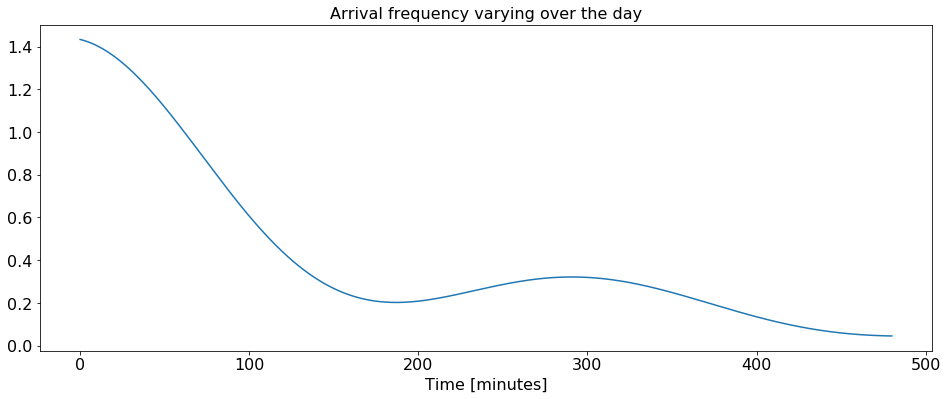

In [59]:
def arrival_freq(t):
    """ Returns the arrival frequency as a function of time (minutes from start of day) """
    return np.exp(-t/200)*(1 + 0.5*np.cos(t*2*np.pi/300 - np.pi/6))

t = np.linspace(0, 480, 481)
plt.figure(figsize=(16,6))
plt.plot(t, arrival_freq(t) )
plt.title('Arrival frequency varying over the day')
plt.xlabel('Time [minutes]')

### Exercise 3
Note in the code above that a function is defined `arrival_freq`, and then plotted. Modify `skier_generator_proc`to use this function when generating inter-arrival times.  

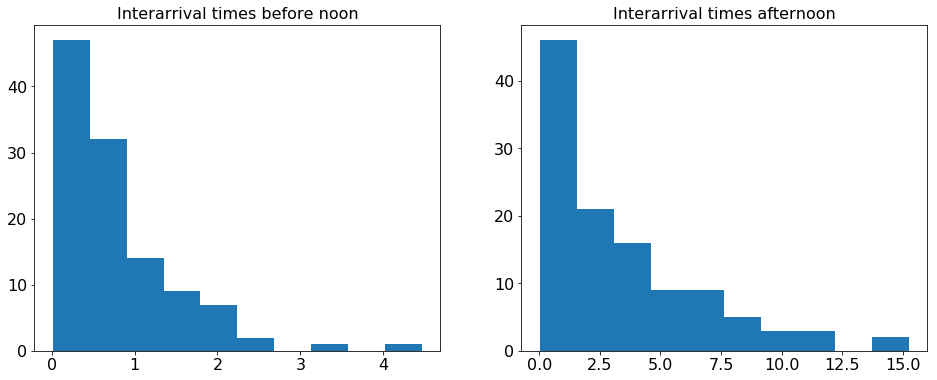

In [65]:
# YOUR CODE HERE
def skier_generator_process(env, lmbda, arrivals):
    """ Implementation of the process that generates arriving customers to the facility.
    
        Arguments
        env       --  simpy simulation environment object
        lmbda     --  the mean arrival frequency
        arrivals  --  a list to hold the time of arrivals
    """
   
    k = 0 # A counter to indicate the number of skiers created
    while True:
        # Endless loop
        yield env.timeout( random.expovariate(arrival_freq(env.now)) ) # Wait for a random interval, depending on time of day
        k += 1
        #print( "Time is %6.2f and skier %d arrives" % (env.now, k) )
        arrivals.append(env.now) # Register the time of arrival
        
env = simpy.Environment() # Create the simulation environment
lmbda = 0.5 # One arrival per two minutes on average
arr = [] # The list of arrival times
env.process( skier_generator_process(env, lmbda, arr) ) # Tell the simulator to process the skier generator process
env.run(until=60*8) # Simulate a day

interArrivalTimesAM = np.diff(np.array(arr[:int(len(arr)/2)])) # The interarrival times first half of the day
interArrivalTimesPM = np.diff(np.array(arr[int(len(arr)/2):])) # The interarrival times second half of the day

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.hist(interArrivalTimesAM)
plt.title('Interarrival times before noon')
plt.subplot(122)
plt.hist(interArrivalTimesPM)
plt.title('Interarrival times afternoon')

## Example 1: A model of an intersection with traffic light
### The traffic light process
Consider the process of a simple traffic light that switches forever from red to green to yellow and back to red. The light is red for one minute, green for 50 seconds and yellow for 10 seconds.

The process will be implemented as a *generator* (see the notebook systemanalys/doc/Introduction to Python.ipynb). The process goes in an infinite loop, pausing in the different states correponding to the color of the light.

In [5]:
def traffic_light_proc(env):
    # The argument env is the simulation environment object. This is needed in order to interact with the simulator
    state = "red";
    while True:   
        # Neverending loop
        print("Time is %6.2f and the traffic light is %s" % (env.now, state))
        yield env.timeout(60) # A timeout event is returned to the simulator. 
        # The timout event will happen after 60 timeunits and then the process will continue 
     
        state = "green"
        print("Time is %6.2f and the traffic light is %s" % (env.now, state))
        yield env.timeout(50) # This event will happen after 50 timeunits.
        
        state = "yellow"
        print("Time is %6.2f and the traffic light is %s" % (env.now, state))
        yield env.timeout(10) # This event will happen after 10 timeunits
        
        state = "red"

env = simpy.Environment() # Create a simulation environment object
env.process(traffic_light_proc(env)) # Tell the environment to process the traffic light
env.run(until=600) # Run the simulation for 600 time units (10 minutes)

Time is   0.00 and the traffic light is red
Time is  60.00 and the traffic light is green
Time is 110.00 and the traffic light is yellow
Time is 120.00 and the traffic light is red
Time is 180.00 and the traffic light is green
Time is 230.00 and the traffic light is yellow
Time is 240.00 and the traffic light is red
Time is 300.00 and the traffic light is green
Time is 350.00 and the traffic light is yellow
Time is 360.00 and the traffic light is red
Time is 420.00 and the traffic light is green
Time is 470.00 and the traffic light is yellow
Time is 480.00 and the traffic light is red
Time is 540.00 and the traffic light is green
Time is 590.00 and the traffic light is yellow


### Checking the state (color) of the traffic light
The color of the traffic light is of course important in a simulation of an intersection. So this information should be readily available to other processes in the simulation model. We can modify the code above to obtain this, using a dictionary to hold the state of the traffic light.

In [7]:
trafficLight = {"state": "red"}
def traffic_light_proc(env, tl):
    # The argument env is the simulation environment object. 
    # The tl argument is a dictionary holding the state (color) of the traffic light
    tl['state'] = "red";
    while True:   
        # Neverending loop
        yield env.timeout(60) # A timeout event is returned to the simulator. 
     
        tl['state'] = "green"
        yield env.timeout(50) # This event will happen after 50 timeunits.
        
        tl['state'] = "yellow"
        yield env.timeout(10) # This event will happen after 10 timeunits
        
        tl['state'] = "red"

env = simpy.Environment() # Create a simulation environment object
env.process(traffic_light_proc(env, trafficLight)) # Tell the environment to process the traffic light

print("Time is %6.2f and the traffic light is %s" % (env.now, trafficLight['state']))
env.run(until=600) # Run the simulation for 600 time units (10 minutes)      
print("Time is %6.2f and the traffic light is %s" % (env.now, trafficLight['state']))

Time is   0.00 and the traffic light is red
Time is 600.00 and the traffic light is yellow


### A car approaches the intersection
It is time to make our model of the intersection somewhat more interesting. Consider the process of a car approaching the intersection. The driver will typically check the state of the traffic light. If it is green or yellow she will continue through the intersection. If the color is red she will stop and wait for the color to change. To make the implementation simpler (for now) we assume that the driver will check the light every eleven seconds to see if it has changed. 

In [14]:
def car_proc(env, tl):
    # Check the state of the traffic light
    if tl['state'] == 'red':
        # Break. Wait and check every 10 seconds until the light changes to green
        while tl['state'] == 'red':
            yield env.timeout(11)
        # Green! Time to go
        print( "Time is %6.2f and the light has changed to %s. Hitting the accelerator." % (env.now, tl['state']) )
    else:
        # Actually not much more to do than drive on
        print( "Time is %6.2f and the light is %s. Driving through." % (env.now, tl['state']) )

trafficLight['state'] = "red"

env = simpy.Environment() # Create a simulation environment object
env.process(traffic_light_proc(env, trafficLight)) # Tell the environment to process the traffic light
env.process(car_proc(env, trafficLight)) # Tell the environment to process the car process

print("Time is %6.2f and the traffic light is %s" % (env.now, trafficLight['state']))
env.run(until=600) # Run the simulation for 600 time units (10 minutes)      
print("Time is %6.2f and the traffic light is %s" % (env.now, trafficLight['state']))

Time is   0.00 and the traffic light is red
Time is  66.00 and the light has changed to green. Hitting the accelerator.
Time is 600.00 and the traffic light is yellow


### Exercise 1.1 Random arrival of the car
In the previous simulation model, the car arrived at the start of the simulation, exactly as the cycle of the traffic light started from red. In a more realistic model, the car arrives at some random point in time. Assume that the time from the start of the simulation until the car arrives at the intersection is modelled 